In [1]:
import bempp.api
import numpy as np
# bempp.api.enable_console_logging()
from scipy.sparse.linalg import gmres
from numpy.linalg import eig
import math

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
nf_default = bempp.api.global_parameters.hmat.cutoff
nf_values = [nf_default, 1E100, 1E10, 1E1, 0]

In [4]:
k = 5
print('The wavenumber: {0}, h = {1}'.format(k, 2*np.pi/(10*k)))
mu_ext = 1

grid = bempp.api.shapes.sphere(h=2*np.pi/(10*k))

The wavenumber: 5, h = 0.12566370614359174


In [5]:
bc_space = bempp.api.function_space(grid, "BC", 0)
rbc_space = bempp.api.function_space(grid, "RBC", 0)
rwg_space = bempp.api.function_space(grid, "RWG", 0)
snc_space = bempp.api.function_space(grid, "SNC", 0)

b_rwg_space = bempp.api.function_space(grid, "B-RWG", 0)
b_snc_space = bempp.api.function_space(grid, "B-SNC", 0)
    

cutoff: 1.797693134862315e+308


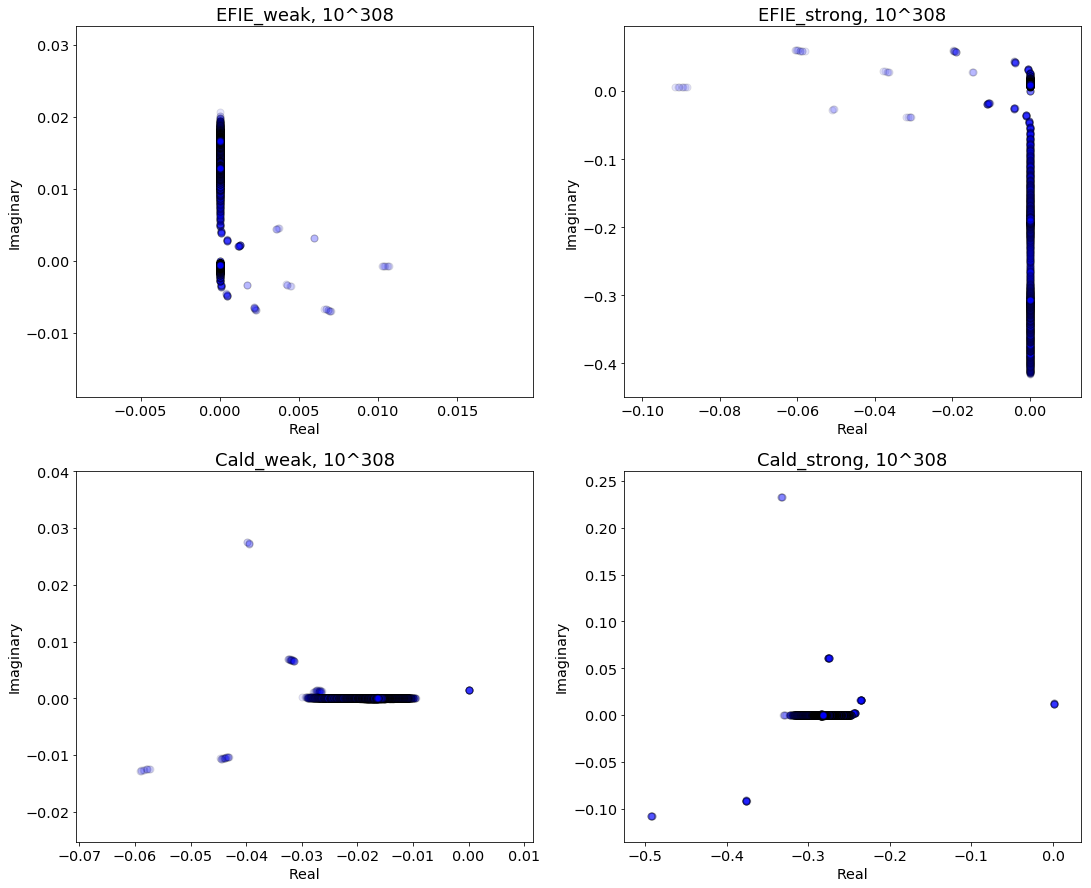

cutoff: 1e+100


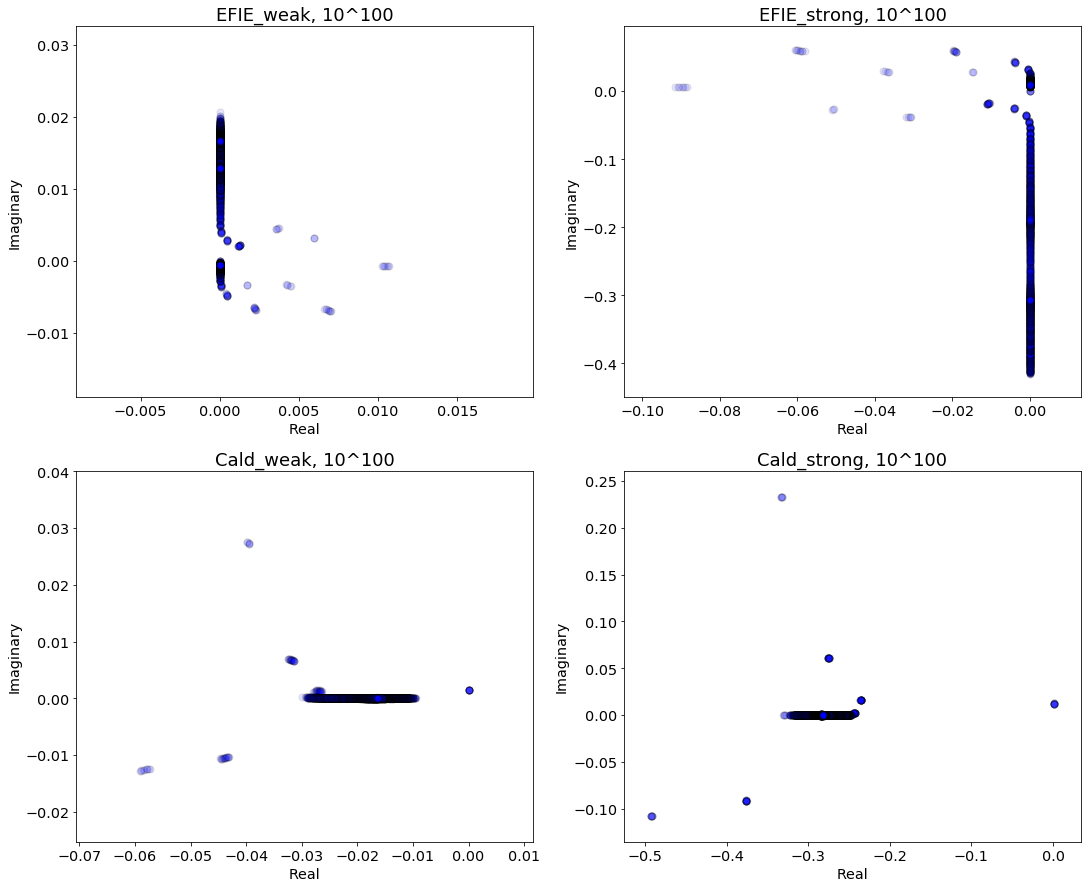

cutoff: 10000000000.0


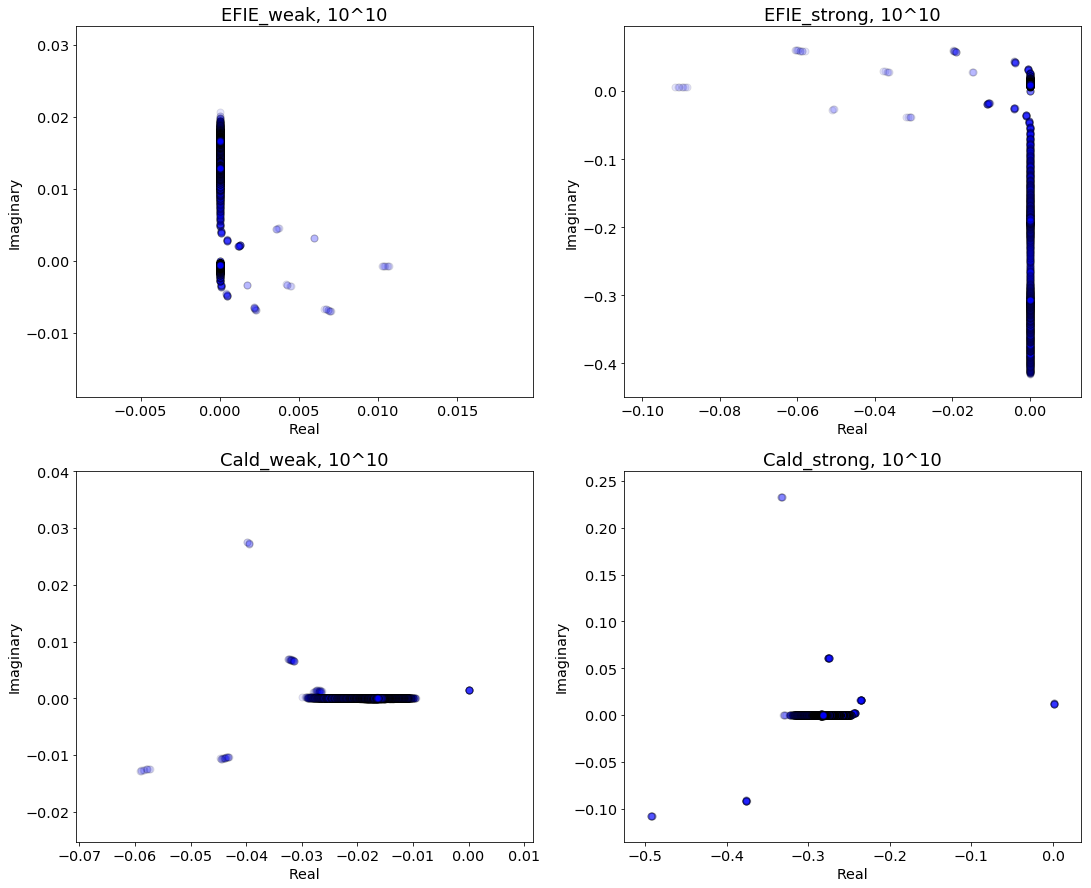

cutoff: 10.0


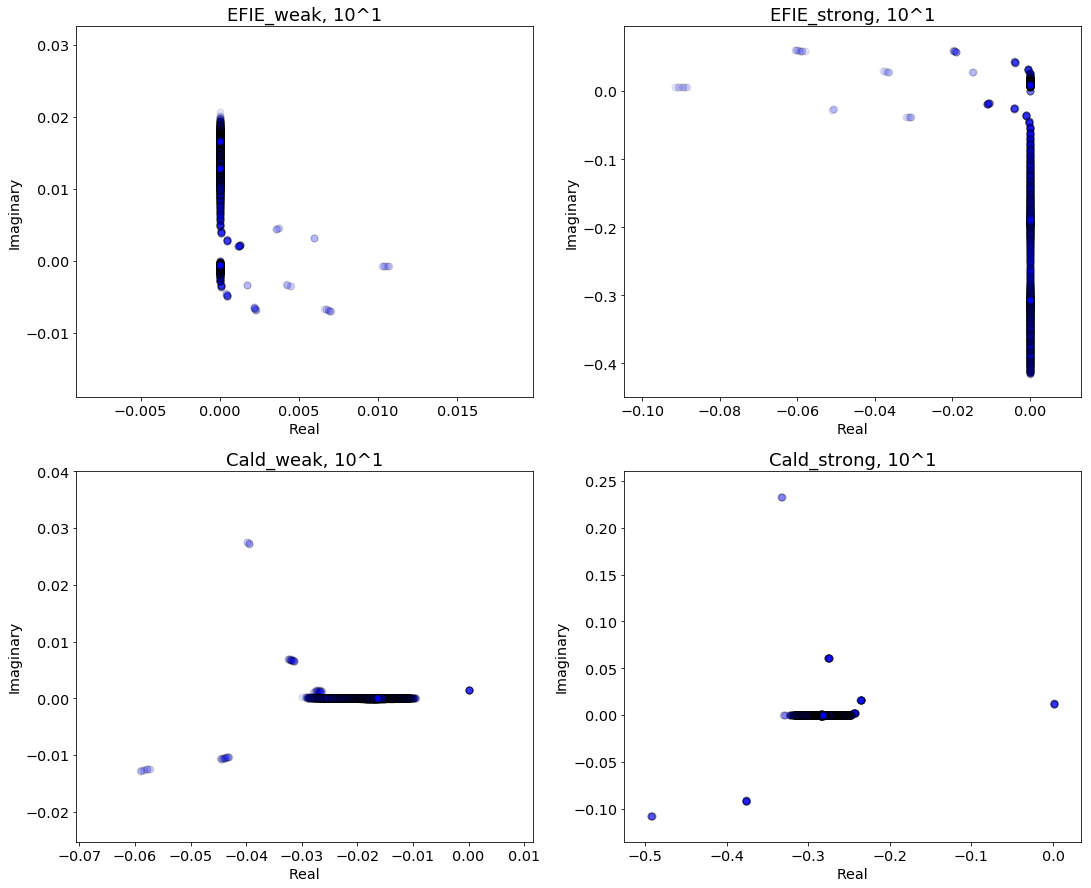

cutoff: 0


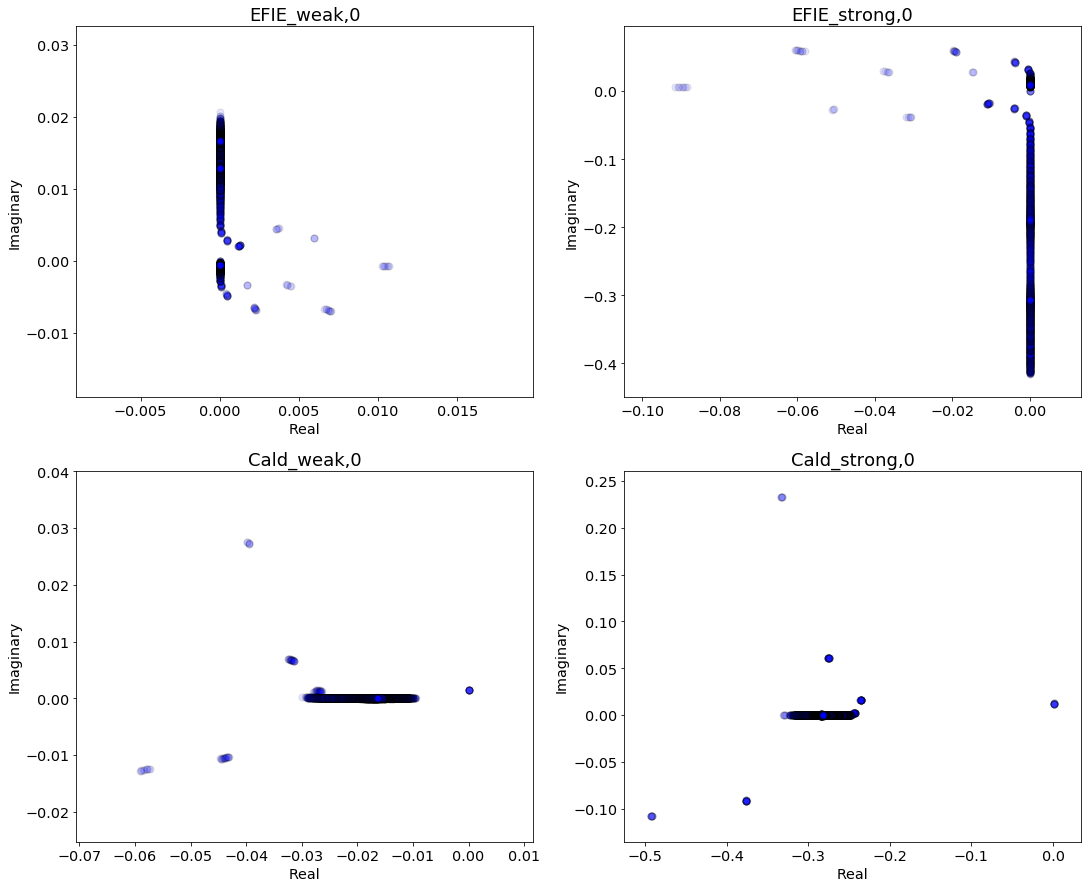

In [6]:
iters_weak = []
iters_strong = []
iters_calderon_weak = []
iters_calderon_strong = []

for nf in nf_values:
    bempp.api.global_parameters.hmat.cutoff = nf
    print("cutoff: {0}".format(nf))
    
    EF = bempp.api.operators.boundary.maxwell.electric_field(rwg_space, rwg_space, snc_space, k)
    EF_weak = EF.weak_form()
    
    EF_pre = bempp.api.operators.boundary.maxwell.electric_field(bc_space, bc_space, rbc_space, k, assemble_only_singular_part=False)
    EF_pre_weak = EF_pre.weak_form()
    
    #set mass matrices
    id_BC_SNC = bempp.api.operators.boundary.sparse.identity(bc_space, bc_space, b_snc_space)
    inv_identity_BC_SNC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BC_SNC.weak_form())

    id_BRWG_RBC = bempp.api.operators.boundary.sparse.identity(b_rwg_space, b_rwg_space, rbc_space)
    inv_identity_BRWG_RBC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BRWG_RBC.weak_form())

      
    EFIE_weak = EF_weak
    EFIE_strong = inv_identity_BC_SNC * EF_weak
    Calderon_weak = EF_pre_weak * inv_identity_BC_SNC * EF_weak
    Calderon_strong = inv_identity_BRWG_RBC * EF_pre_weak * inv_identity_BC_SNC * EF_weak
    
    EFIE_weak_matrix = bempp.api.as_matrix(EFIE_weak)
    EFIE_strong_matrix = bempp.api.as_matrix(EFIE_strong)
    Calderon_weak_matrix = bempp.api.as_matrix(Calderon_weak)
    Calderon_strong_matrix = bempp.api.as_matrix(Calderon_strong)
    
    eigs_EFIE_weak, evals = eig(EFIE_weak_matrix)
    eigs_EFIE_strong, evals = eig(EFIE_strong_matrix)
    eigs_Calderon_weak, evals = eig(Calderon_weak_matrix)
    eigs_Calderon_strong, evals = eig(Calderon_strong_matrix)
    
    if nf == 0:
        f, axarr = plt.subplots(2, 2, figsize=(18, 15))
        axarr[0, 0].scatter(eigs_EFIE_weak.real, eigs_EFIE_weak.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[0, 0].set_title('EFIE_weak,' + str(nf), fontsize = 18)
        axarr[0, 1].scatter(eigs_EFIE_strong.real, eigs_EFIE_strong.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[0, 1].set_title('EFIE_strong,' + str(nf), fontsize = 18)
        axarr[1, 0].scatter(eigs_Calderon_weak.real, eigs_Calderon_weak.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[1, 0].set_title('Cald_weak,' + str(nf), fontsize = 18)
        axarr[1, 1].scatter(eigs_Calderon_strong.real, eigs_Calderon_strong.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[1, 1].set_title('Cald_strong,' + str(nf), fontsize = 18)
        for ax in axarr.flat:
            ax.set(xlabel='Real', ylabel='Imaginary')
        plt.show()
    else:
        f, axarr = plt.subplots(2, 2, figsize=(18, 15))
        axarr[0, 0].scatter(eigs_EFIE_weak.real, eigs_EFIE_weak.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[0, 0].set_title('EFIE_weak, 10^' + str(int(math.log(nf,10))), fontsize = 18)
        axarr[0, 1].scatter(eigs_EFIE_strong.real, eigs_EFIE_strong.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[0, 1].set_title('EFIE_strong, 10^' + str(int(math.log(nf,10))), fontsize = 18)
        axarr[1, 0].scatter(eigs_Calderon_weak.real, eigs_Calderon_weak.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[1, 0].set_title('Cald_weak, 10^' + str(int(math.log(nf,10))), fontsize = 18)
        axarr[1, 1].scatter(eigs_Calderon_strong.real, eigs_Calderon_strong.imag, color='b', s=50, alpha=.1, edgecolors='black')
        axarr[1, 1].set_title('Cald_strong, 10^' + str(int(math.log(nf,10))), fontsize = 18)
        for ax in axarr.flat:
            ax.set(xlabel='Real', ylabel='Imaginary')
        plt.show()
